In [1]:
from transactions_assessment.loaders.data_loaders import TransactionLoader, ModelDataLoader
from transactions_assessment.detectors.detector_models import RFDetector
from transactions_assessment.logging import logging_config
from pandas_profiling import ProfileReport
from logging.config import dictConfig

In [2]:
dictConfig(logging_config)

# change path here to wherever data file is stored
data_file = "../data/transactions.txt"

# Question 1
In the next few cells I am going to answer the items in question 1. For loading the data, I am going to use a custom data loader class, we can get the number of rows and columns by calling the 'shape' attribute of the pandas dataframe. I am going to use a python package call "pandas profiling" to quickly get a summary of the dataset. 
- Data is loaded below
- The data has 786,363 rows and 29 columns
- Pandas Profiling was used to get the summary statistics for each field

In [21]:
loader = TransactionLoader(data_file)

In [22]:
df = loader.load_unprocessed()

2021-03-01 18:06:54,676 transactions_assessment.loaders INFO     Reading data file records
2021-03-01 18:07:12,297 transactions_assessment.loaders INFO     786363 out of 786363 lines successfully read.


In [26]:
# the output of the pandas profile report can be found in the summary_report.html file in the notebooks directory. 
#I'm commenting this out to save my reveiwers from an awfully 
# long time to wait. to re-create the results, just uncomment the bottom line below and run cell. 
# I'm leaving it commented out for now. It also looks like my logging config
# is not set to disable the matplotlib logger, so you will get a lot of logging info unfortunately..

#profile = ProfileReport(df, title="transactional summary", explorative=True)

In [1]:
# profile.to_notebook_iframe()

# Question 2
- Plot a histogram of the processed amounts of each transaction, the transactionAmount column
- Report any structure you find and any hypotheses you have about that structure

Although we already have the histogram produced in the above pandas-profiling report, below is another histogram produced using the pandas built-in method "hist". 
We can see by looking at this histogram that the max is over 2000 (2011.54), the min is 0, and the mean is 136.98.
There are a lot of records that have a small value for this field, skewing the distribution heavily to the right. We will probably want to transform this variable using something like a log-transformation later when we start modeling.

<AxesSubplot:>

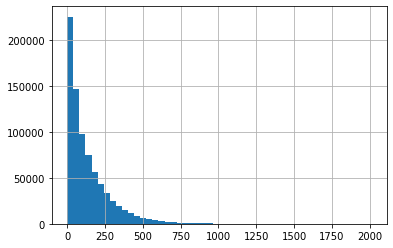

In [7]:
df.transactionAmount.hist(bins=50)

# Question 3
- Can you programmatically identify reversed and multi-swipe transactions?
- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
- Did you find anything interesting about either kind of transaction?

From a quick look at the transactionType variable, I can see that there are three unique types: Purchase, Address_verification, and Reversal. So assuming those labels are correct, we can identify the reversal transactions by locating the transations with the transactionType value of 'REVERSAL'. There does not seem to be a label for multi-swipe, however. My first thought is that we may be able to get these transactions by looking at the transactionDate variable and labeling transactions as "multi-swipe" if two transactions occur within some time window. 

Since comparing  each date-time to every row in the dataset would be costly computationally, I am going to first sort the dataframe by transactionDate, then loop through each transationDateTime value starting with the second value (we are calling the first value of a series of multi-swipes "normal", so the first value will always be "normal"). For each iteration, I will compare the current value to the previous value. If the current value is within some time window of the previous value, I will mark that row as a 'multi-swipe'. I will also use account number and transaction amount to further dictate what is considered a multi-swipe. Additionaly I will only label transactions as multi-swipe if the transationType is "Purchase" (and all other conditions are met).


The end result will be a new column called "multi-swipe' where each value will be either 0, for not multiswipe or 1, for multiswipe. Since this variable will likely be useful for modeling, I am going to implement this logic in the TransactionLoader class. I am also not sure about the format of the transactionDate column its obviously a string currently but it looks kind of weird (ex: '2016-05-28T14:24:41' - what is that 'T' doing in there) so I will probably have to turn this value into a propper date-time type while I'm at it. While I could do this in the base DataLoader class where I am parsing though each line of the text file, I would rather implement this in the child class TransactionLoader in order to keep the loading of raw data seperate from any kind of preprocessing. 

After experimenting with different time windows, I have chosen 5 minutes to be the cut-off. It seems that increasing from 5 minutes doesn't yeild much of an increase in transactions classified as "multi-swipe". My reasoning here is that without knowing exactly how long a credit card transaction takes to be logged, I have to choose a somewhat arbitrary cut-off time. It is probably pretty unusual for a person to repeat the exact same transation within 5 minutes. While this same logic could apply to a larger time window, there does not seem to be much of an increase in detected multi-swipes and at some point, we can expect those transactions to be "valid", recurring purchases.

## Answers
- Yes, general approach is described above
- number of transactions and transaction total amount
    - Multi swipe number of transactions: 7373
    - Multi swipe total transaction amount: \$1009589.19
    - Reversals number of transactions: 20303
    - Reversals total transaction amount: \$2821792.5
- Interesting things:


In [ ]:
preprocessed_df = loader.preprocess_data()

In [33]:
multi_swipes = preprocessed_df.loc[preprocessed_df.multi_swipe == 1].transactionAmount
print(f'Sum of transaction amounts from multi-swipes: {multi_swipes.sum()}')
print(f'Total transactions classified as multi-swipe (using 5 minute time-window): {multi_swipes.shape[0]}')


Sum of transaction amounts from multi-swipes: 1009589.19
Total transactions classified as multi-swipe (using 5 minute time-window): 7373


In [34]:
reversals = preprocessed_df.loc[preprocessed_df.transactionType.apply(lambda k: k.lower()) == 'reversal']
print(f'Sum of transaction amounts from reversals: {reversals.transactionAmount.sum()}')
print(f'Total transactions classified as reversals: {reversals.shape[0]}')

Sum of transaction amounts from reversals: 2821792.5000000005
Total transactions classified as reversals: 20303


# Question 4
- Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
- Provide an estimate of performance using an appropriate sample, and show your work.
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

From examining the data in the above questions, I see that there are quite a few categorical variables that will need to be preprocessed prior to fitting any type of model. After looking at the value counts, I can see that many of these have thousands of different values. 

My approach to modeling is going to be focused around rapid prototyping. I want to be able to quickly test out differnt models with different processing methods without waiting many minutes for each model train. To accomplish this, I am going to start by throwing out the 'problem' variables (cats with lots of distinct values). Depending on where I am on time, and how well my model is doing, I can go back focus on the variables I discarded originally. I'm going to restrict the size of the dataset to a point where I can load, fit, and score a model in less than a minute so that I can get a rough guess of how well my model is doing.

I am going to start with a random forest classifier. Typically, these are pretty quick to train and are a good starting point. We dont have to worry about satisfying any statistical assumptions or whether or not the accuracy can be trusted. If a random forest fails horribly, we can usually assume that we either did something wrong with the pre-processing, or we are asking the wrong question of the dataset.

In [3]:
# using the first 100,000 records
data_loader = ModelDataLoader(data_file, limit=100000)
x_train, x_test, y_train, y_test = data_loader.preprocess_data()

2021-03-02 13:04:11,196 transactions_assessment.loaders INFO     Reading data file records
2021-03-02 13:04:13,032 transactions_assessment.loaders INFO     100000 out of 100000 lines successfully read.


In [4]:
rf_detector = RFDetector()

In [5]:
# heres what the current pipeline looks like
rf_detector.pipe

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

In [6]:
rf_detector.train(x_train, y_train)

2021-03-02 13:04:29,147 RFDetector   INFO     Training model..
2021-03-02 13:04:39,997 RFDetector   INFO     Model training complete.


In [7]:
rf_detector.print_score(x_train, y_train, x_test, y_test)

train score: 0.999975 test score: 0.98685


So it looks like my model did pretty well. Training and test scores are 99 and 98 percent. However I have a guess of why thats the case..

In [8]:
rf_detector.print_confusion(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19686
           1       0.93      0.18      0.29       314

    accuracy                           0.99     20000
   macro avg       0.96      0.59      0.64     20000
weighted avg       0.99      0.99      0.98     20000



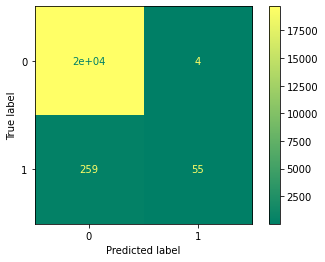

In [10]:
rf_detector.plot_confusion(x_test, y_test)

From looking at the confusion matrix, I can see that there are very few cases of fraud. As seen in the clasification report above, the model's recall is very low, meaning that it's labeleling a lot of fraud cases as not-fraud. 

The cause of this is likley due to an imbalanced dataset (lots of examples from one class -in this case, not-fraud. I am going to use over-sampling to repeated duplicate random examples of fraud. This will lead to an large increase in the number of observations in our dataset. To keep the training time relatively low, I am going to use sub-sampling from the new balanced dataset to randomly select a sample of observations with replacement from the dataset for each estimator.

In [11]:
rf_detector.set_samples(sampling_strategy='minority')
rf_detector.use_bootstrap(max_samples=.1)

In [12]:
rf_detector.train(x_train, y_train)

2021-03-02 13:10:40,487 RFDetector   INFO     Training model..
2021-03-02 13:10:46,353 RFDetector   INFO     Model training complete.


In [13]:
rf_detector.print_score(x_train, y_train, x_test, y_test)

train score: 0.993025 test score: 0.97835


In [15]:
rf_detector.print_confusion(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19686
           1       0.32      0.34      0.33       314

    accuracy                           0.98     20000
   macro avg       0.66      0.67      0.66     20000
weighted avg       0.98      0.98      0.98     20000



Ok, great so our recall increased, but our presicion decreased. I'm now going to try tuning the hyperparamters of the random forest to see if I the defaults happend to be really bad for this use case.

In [18]:
# heres what parameters we are searching via randomized grid search
rf_detector.param_grid

{'rf__n_estimators': [50, 100, 200, 500],
 'rf__max_depth': [None, 10, 30, 50, 70, 100],
 'rf__min_samples_split': [2, 4, 8],
 'rf__max_features': ['sqrt', 'auto'],
 'rf__max_samples': [0.1, 0.5]}

In [16]:
rf_detector.grid_search(x_train, y_train, n_iter=20)

best params: {'rf__n_estimators': 50, 'rf__min_samples_split': 8, 'rf__max_samples': 0.5, 'rf__max_features': 'sqrt', 'rf__max_depth': None} 
 best score: 0.8363308270676691


In [19]:
# inserting the parameters back into the pipeline's random forest
rf_params = {'rf__n_estimators': 50,
             'rf__min_samples_split': 8,
             'rf__max_samples': 0.5,
             'rf__max_features': 'sqrt',
             'rf__max_depth': None}
rf_detector.pipe.set_params(**rf_params)

Pipeline(steps=[('sampler', RandomOverSampler(sampling_strategy='minority')),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_features='sqrt', max_samples=0.5,
                                        min_samples_split=8,
                                        n_estimators=50))])

In [22]:
rf_detector.pipe.set_params(**{'rf__n_estimators': 200, 'rf__min_samples_split': 8, 'rf__max_samples': 0.5, 'rf__max_features': 'auto', 'rf__max_depth': 50})

Pipeline(steps=[('sampler', RandomOverSampler(sampling_strategy='minority')),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=50, max_samples=0.5,
                                        min_samples_split=8,
                                        n_estimators=200))])

In [20]:
# making sure that my parameters were acutally loaded (looks abbreviated in the above output)
rf_detector.pipe.get_params()

{'memory': None,
 'steps': [('sampler', RandomOverSampler(sampling_strategy='minority')),
  ('scaler', StandardScaler()),
  ('rf',
   RandomForestClassifier(max_features='sqrt', max_samples=0.5,
                          min_samples_split=8, n_estimators=50))],
 'verbose': False,
 'sampler': RandomOverSampler(sampling_strategy='minority'),
 'scaler': StandardScaler(),
 'rf': RandomForestClassifier(max_features='sqrt', max_samples=0.5,
                        min_samples_split=8, n_estimators=50),
 'sampler__random_state': None,
 'sampler__sampling_strategy': 'minority',
 'sampler__shrinkage': None,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': 0.5,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_sam

In [23]:
# refitting with updated hyper-parameters
rf_detector.train(x_train, y_train)
rf_detector.print_confusion(x_test, y_test)

2021-03-02 13:31:09,838 RFDetector   INFO     Training model..
2021-03-02 13:31:35,927 RFDetector   INFO     Model training complete.


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19686
           1       0.84      0.25      0.39       314

    accuracy                           0.99     20000
   macro avg       0.91      0.63      0.69     20000
weighted avg       0.99      0.99      0.98     20000



In [17]:
# increasing the dataset to include all data
# set bootstrap max samples to 0.05
# Note: the next few cells will take a couple minutes to run
data_loader.limit=None
x_train, x_test, y_train, y_test = data_loader.preprocess_data()
rf_detector.use_bootstrap(max_samples=0.05)

2021-03-01 17:44:23,408 transactions_assessment.loaders INFO     Reading data file records
2021-03-01 17:44:40,267 transactions_assessment.loaders INFO     786363 out of 786363 lines successfully read.


In [18]:
rf_detector.train(x_train, y_train)

2021-03-01 17:46:28,995 RFDetector   INFO     Training model..
2021-03-01 17:49:03,650 RFDetector   INFO     Model training complete.


In [19]:
rf_detector.print_confusion(x_train, y_train)

true positive: 54525 true negative: 564662 
false_positive: 9903 false negative: 0 
f1 score: 0.9167486318125646


In [20]:
rf_detector.print_confusion(x_test, y_test)

true positive: 15756 true negative: 139003 
false_positive: 735 false negative: 1779 
f1 score: 0.9261153235760888


After loading in all of the data, we are able to get a pretty decent f1 score. We can see that the data is pretty well balanced unlike before. At this point, I am going to stop here. If I had more time I would focus on feature engineering and eventual tuning hyper-parameters, but I'm not sure if the juice is worth the squeeze there. If you look at the RFDetector and Detector classes, you can probably tell that's where I was planning on going -it wasn't intentially over-engineered. my plan was to be able to utilize the base Detector class to create more detectors with different model types. So if I had more time I would test out different classifiers, and use Randomized grid-search to tune the hyperparameters of the final model. Looking back, I probably spend too much time trying to create tools to make my work easier over the long run, but it turned out that I got too ahead of myself and ended up not having enough time to do the actual experiments I had planned. Overall, I'm not too dissapointed with my model. The main challenge of using this dataset seemed to be getting it to be balanced. Once that was done, the model almost trains itself.. I think that even with additional models, fine-tuning, and feature engineering, we could get a marginally better-fitting model but maybe not too much better than what is presented here.